# Noise vs Gate Option — Original Gate Set (H, CX, I)

This notebook generates **4 plots** (one per noise type).  
The x-axis is a **gate option** applied at the **start of each distillation block**, restricted to your *original* gate set:

- **I**: do nothing  
- **H**: Hadamard on selected qubits  
- **CX**: CNOT on selected control→target pairs  

No alternative 2-qubit gates (ECR, iSWAP, SWAP, etc.) are used and **no substitutions** are performed.

> You must set which qubits/pairs the block-prefix operation acts on in `BLOCK_PREFIX_TARGETS`.

## What were ECR, iSWAP, and SWAP in the earlier notebook?

They were **extra** 2‑qubit gates I included as optional comparisons. They are *not* part of a standard “H/CX/I-only” circuit description.

- **SWAP**: exchanges the quantum states of two qubits: \(|a\rangle|b\rangle \to |b\rangle|a\rangle\).
- **iSWAP**: like SWAP but adds a phase of \(i\) to the \(|01\rangle\) and \(|10\rangle\) amplitudes:
  it maps \(|01\rangle\to i|10\rangle\), \(|10\rangle\to i|01\rangle\).
- **ECR** (“echoed cross-resonance”): a native entangling gate used on IBM hardware, built from cross-resonance interactions and an echo sequence.
  It’s hardware-motivated, not a “logical CX replacement” unless you deliberately compile to it.

If you want the **original circuits exactly**, you should **not** include those gates at all — which is what this notebook does.

In [1]:
# If needed:
# !pip -q install qiskit qiskit-aer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr
from qiskit_aer import AerSimulator

In [2]:
# Bell state basis vectors (order: |00>,|01>,|10>,|11>)
bell_states = {
    "phi+": np.array([1, 0, 0, 1], dtype=complex) / np.sqrt(2),
    "phi-": np.array([1, 0, 0, -1], dtype=complex) / np.sqrt(2),
    "psi+": np.array([0, 1, 1, 0], dtype=complex) / np.sqrt(2),
    "psi-": np.array([0, 1, -1, 0], dtype=complex) / np.sqrt(2),
}

def build_pair_state(f: float, a: float, b: float, c: float) -> np.ndarray:
    """Return normalized 2-qubit Bell-superposition state vector in computational basis."""
    norm = np.sqrt(f*f + a*a + b*b + c*c)
    if norm == 0:
        raise ValueError("At least one coefficient must be nonzero.")
    f, a, b, c = f/norm, a/norm, b/norm, c/norm
    return (
        f * bell_states["phi+"]
        + a * bell_states["phi-"]
        + b * bell_states["psi+"]
        + c * bell_states["psi-"]
    )

In [3]:
# ====== Configure your ORIGINAL block-prefix options (H / CX / I) ======

# X-axis options (keep exactly these if you want only original gate set)
GATE_OPTIONS = ["base", "i", "h", "cx"]


# You must specify which qubits/pairs each block-prefix operation touches.
# Adjust these to match your original circuit definition.
#
# - For "h": apply H to each qubit in h_qubits
# - For "cx": apply CX for each (control, target) pair in cx_pairs
# - For "i": do nothing (or you can optionally apply qc.id on a list, but it is redundant)

BLOCK_PREFIX_TARGETS = {
    "block1": {
        "h_qubits": [0, 5],          # <-- EDIT ME
        "cx_pairs": [(2, 0), (3, 5)]  # <-- EDIT ME
    },
    "block2": {
        "h_qubits": [1, 4],          # <-- EDIT ME
        "cx_pairs": [(2, 1), (3, 4)]  # <-- EDIT ME
    }
}

In [4]:
def apply_block_prefix(qc: QuantumCircuit, block_name: str, option: str) -> None:
    """Apply the chosen original-gate prefix (or baseline) at the start of a block."""
    opt = option.lower().strip()
    targets = BLOCK_PREFIX_TARGETS[block_name]

    if opt == "base":
        # Baseline: do not add anything; block runs as originally written
        return

    if opt == "i":
        # IMPORTANT:
        # If your "i" option is NOT identity and is actually a nontrivial gate pattern,
        # implement it here (instead of return).
        return

    if opt == "h":
        for q in targets["h_qubits"]:
            qc.h(q)
        return

    if opt == "cx":
        for c, t in targets["cx_pairs"]:
            qc.cx(c, t)
        return

    raise ValueError(f"Unknown option: {option}. Expected one of {GATE_OPTIONS}")


In [5]:
# ====== Your circuit (keep everything exact here) ======
# IMPORTANT:
# - This function is where you ensure the circuit is exactly your original design.
# - I left the body matching the earlier structure you had, but you should replace it
#   with your exact original H/CX/I-only blocks if that’s what you actually use.

def create_circuit(block1_prefix: str = "i", block2_prefix: str = "i") -> QuantumCircuit:
    qr = QuantumRegister(6)
    cr = ClassicalRegister(6)
    qc = QuantumCircuit(qr, cr)

    th = np.pi / 2

    # -------- Block 1 --------
    apply_block_prefix(qc, "block1", block1_prefix)

    qc.rx(th, qr[0])
    qc.rx(-th, qr[5])
    qc.rx(th, qr[2])
    qc.rx(-th, qr[3])

    qc.cx(qr[2], qr[0])
    qc.cx(qr[3], qr[5])

    qc.rx(-th, qr[2])
    qc.rx(th, qr[3])

    qc.measure(qr[0], cr[0])
    qc.measure(qr[5], cr[1])
    qc.store(cr[0], expr.bit_xor(cr[0], cr[1]))

    # -------- Block 2 --------
    apply_block_prefix(qc, "block2", block2_prefix)

    qc.rx(th, qr[1])
    qc.rx(-th, qr[4])
    qc.rx(th, qr[2])
    qc.rx(-th, qr[3])

    qc.cx(qr[2], qr[1])
    qc.cx(qr[3], qr[4])

    qc.rx(-th, qr[2])
    qc.rx(th, qr[3])

    qc.measure(qr[1], cr[2])
    qc.measure(qr[4], cr[3])
    qc.store(cr[2], expr.bit_xor(cr[2], cr[3]))
    qc.store(cr[0], expr.bit_or(cr[0], cr[2]))

    # -------- Final (as before) --------
    qc.cx(qr[2], qr[3])
    qc.h(qr[2])
    qc.measure(qr[2], cr[4])
    qc.measure(qr[3], cr[5])

    return qc

In [6]:
def analyze(f: float, a: float, b: float, c: float, *,
            block1_prefix: str = "i", block2_prefix: str = "i",
            shots: int = 100_000, seed: int = 0):
    """Run simulation and return (fidelity, success_rate) from the same postselection rule."""
    pair = build_pair_state(f, a, b, c)

    # 6-qubit product of 3 identical pairs: (q0,q5), (q1,q4), (q2,q3)
    state_6q = np.zeros(64, dtype=complex)
    for q0 in range(2):
        for q1 in range(2):
            for q2 in range(2):
                for q3 in range(2):
                    for q4 in range(2):
                        for q5 in range(2):
                            idx = q5*32 + q4*16 + q3*8 + q2*4 + q1*2 + q0
                            state_6q[idx] = pair[q0 + 2*q5] * pair[q1 + 2*q4] * pair[q2 + 2*q3]

    qr = QuantumRegister(6)
    cr = ClassicalRegister(6)
    qc = QuantumCircuit(qr, cr)
    qc.initialize(state_6q, qr)
    qc.compose(create_circuit(block1_prefix=block1_prefix, block2_prefix=block2_prefix), inplace=True)

    # No transpile: keep the circuit as-written.
    simulator = AerSimulator(seed_simulator=seed)
    counts = simulator.run(qc, shots=shots).result().get_counts()

    accepted = 0
    success = 0

    # Same acceptance + success logic as before
    for bitstring, n in counts.items():
        if bitstring[-1] == "0":
            accepted += n
            if bitstring[0] == "0" and bitstring[1] == "0":
                success += n

    if accepted == 0:
        return np.nan, 0.0

    fidelity = success / accepted
    success_rate = accepted / shots
    return fidelity, success_rate

In [7]:
# ==== Experiment configuration ====

# 4 noise types (one plot each)
NOISE_TYPES = ["phi-", "psi+", "psi-", "depolarized"]
NOISE_STRENGTH = 0.3

SHOTS = 100_000
SEED = 0

METRIC = "fidelity"          # "fidelity" or "success_rate"
PLOT_SUCCESS_RATE_TOO = True # overlays success rate on a twin axis

In [8]:
def coeffs_for_noise(noise_type: str, noise_strength: float):
    """Return (f,a,b,c) coefficients for the requested 'noise type'."""
    nt = noise_type.lower().strip()
    if nt == "phi-":
        return (1.0, noise_strength, 0.0, 0.0)
    if nt == "psi+":
        return (1.0, 0.0, noise_strength, 0.0)
    if nt == "psi-":
        return (1.0, 0.0, 0.0, noise_strength)
    if nt == "depolarized":
        return (1.0, noise_strength, noise_strength, noise_strength)
    raise ValueError(f"Unknown noise type: {noise_type}")


rows = []

# Precompute a fixed ordering of 2-gate options (for the x-axis)
GATE_PAIRS = [
    f"{g1}-{g2}"
    for g1 in GATE_OPTIONS
    for g2 in GATE_OPTIONS
]

for noise in NOISE_TYPES:
    f, a, b, c = coeffs_for_noise(noise, NOISE_STRENGTH)

    # 🔁 every option of two blocks, prefixed by two of the selected gates
    for opt1 in GATE_OPTIONS:         # prefix for block 1
        for opt2 in GATE_OPTIONS:     # prefix for block 2
            fid, sr = analyze(
                f, a, b, c,
                block1_prefix=opt1,
                block2_prefix=opt2,
                shots=SHOTS,
                seed=SEED
            )
            rows.append({
                "noise_type":    noise,
                "gate_pair":     f"{opt1}-{opt2}",  # label for x-axis
                "block1_prefix": opt1,
                "block2_prefix": opt2,
                "fidelity":      fid,
                "success_rate":  sr,
            })

df = pd.DataFrame(rows)
df

,noise_type,gate_pair,block1_prefix,block2_prefix,fidelity,success_rate
0,phi-,base-base,base,base,0.999238,0.77438
1,phi-,base-i,base,i,0.999238,0.77438
2,phi-,base-h,base,h,0.999303,0.77438
3,phi-,base-cx,base,cx,0.912233,0.85032
4,phi-,i-base,i,base,0.999238,0.77438
...,...,...,...,...,...,...
59,depolarized,h-cx,h,cx,0.876856,0.56365
60,depolarized,cx-base,cx,base,0.879661,0.56341
61,depolarized,cx-i,cx,i,0.879661,0.56341
62,depolarized,cx-h,cx,h,0.879093,0.56341


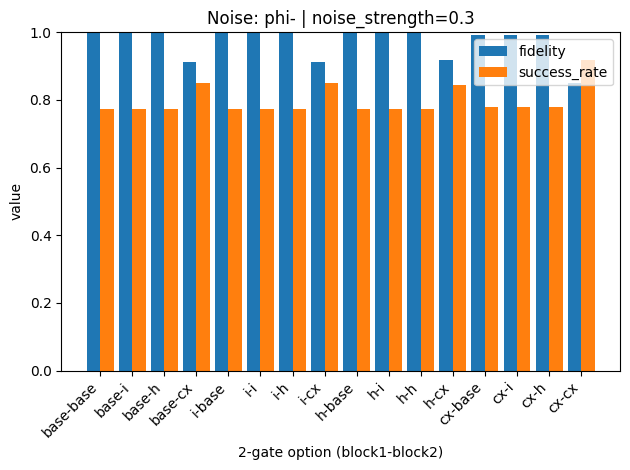

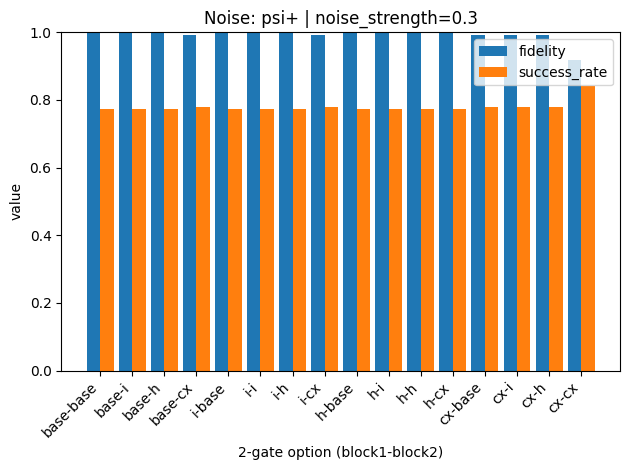

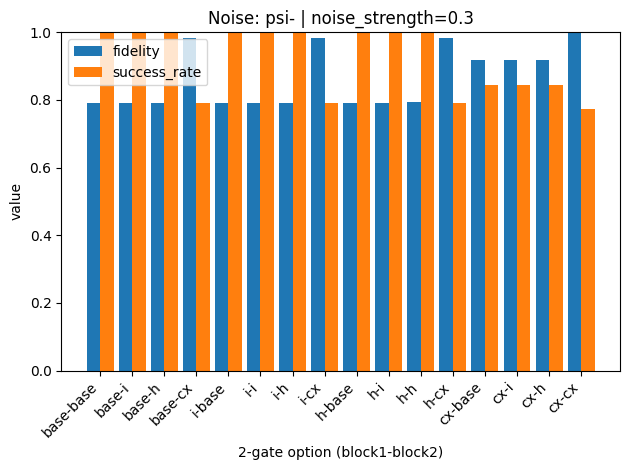

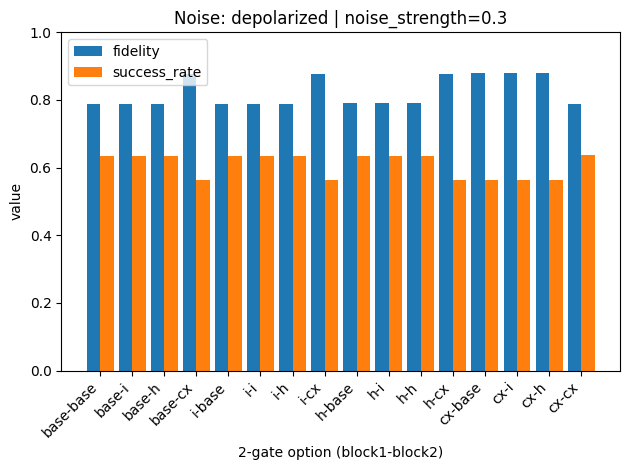

In [9]:
# ==== 4 graphs: one per noise type ====
# Grouped bars: fidelity + success_rate

import numpy as np

for noise in NOISE_TYPES:
    sub = df[df["noise_type"] == noise].copy()
    sub["gate_pair"] = pd.Categorical(sub["gate_pair"], categories=GATE_PAIRS, ordered=True)
    sub = sub.sort_values("gate_pair")

    xlabels = sub["gate_pair"].astype(str).tolist()
    x = np.arange(len(xlabels))

    fid = sub["fidelity"].to_numpy()
    sr  = sub["success_rate"].to_numpy()

    width = 0.42  # bar width

    fig, ax = plt.subplots()
    ax.bar(x - width/2, fid, width, label="fidelity")
    ax.bar(x + width/2, sr,  width, label="success_rate")

    ax.set_title(f"Noise: {noise} | noise_strength={NOISE_STRENGTH}")
    ax.set_xlabel("2-gate option (block1-block2)")
    ax.set_ylabel("value")
    ax.set_ylim(0, 1.0)

    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=45, ha="right")

    ax.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# ---- Visualize circuit-design × noise-profile test results ----
# Expected input (any one of these):
#   1) RESULTS: list[dict] with keys: circuit, noise, fidelity, success_rate
#   2) df: a pandas DataFrame with columns: circuit, noise, fidelity, success_rate
# If neither exists, this cell can optionally RUN a small sweep using your existing analyze-style setup.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _as_label(x):
    """Pretty label for circuit designs like ('I','H','X') or ['I','H','X'] or objects."""
    if isinstance(x, (tuple, list, np.ndarray)):
        return "".join(map(str, x))  # e.g., ('I','H','X') -> "IHX"
    return str(x)

def _get_df():
    # Case A: user already has a DataFrame called df
    if "df" in globals() and isinstance(globals()["df"], pd.DataFrame):
        _df = globals()["df"].copy()
    # Case B: user has a list of dicts called RESULTS or results
    elif "RESULTS" in globals():
        _df = pd.DataFrame(globals()["RESULTS"])
    elif "results" in globals():
        _df = pd.DataFrame(globals()["results"])
    else:
        _df = None

    if _df is None or _df.empty:
        return None

    # Normalize/ensure columns
    rename_map = {}
    for c in _df.columns:
        lc = c.lower().strip()
        if lc in ("circuit", "design", "circuit_design"):
            rename_map[c] = "circuit"
        elif lc in ("noise", "noise_profile", "profile"):
            rename_map[c] = "noise"
        elif lc in ("fidelity", "fid"):
            rename_map[c] = "fidelity"
        elif lc in ("success_rate", "success", "accept_rate", "accepted_rate"):
            rename_map[c] = "success_rate"
    _df = _df.rename(columns=rename_map)

    required = {"circuit", "noise", "fidelity", "success_rate"}
    missing = required - set(_df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}. "
                         f"Need: {sorted(required)}; got: {sorted(_df.columns)}")

    _df["circuit"] = _df["circuit"].map(_as_label)
    _df["noise"] = _df["noise"].map(str)
    _df["fidelity"] = pd.to_numeric(_df["fidelity"], errors="coerce")
    _df["success_rate"] = pd.to_numeric(_df["success_rate"], errors="coerce")
    _df = _df.dropna(subset=["fidelity", "success_rate"])
    return _df

def _annotated_heatmap(pivot, title, fmt="{:.3f}"):
    # pivot: index=circuit, columns=noise
    data = pivot.values
    fig, ax = plt.subplots()
    im = ax.imshow(data, aspect="auto")
    ax.set_title(title)

    ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_yticklabels(pivot.index.tolist())
    ax.set_xticks(np.arange(pivot.shape[1]))
    ax.set_xticklabels(pivot.columns.tolist(), rotation=45, ha="right")

    # Annotate cells (skip if too large)
    if pivot.shape[0] * pivot.shape[1] <= 300:
        for i in range(pivot.shape[0]):
            for j in range(pivot.shape[1]):
                v = data[i, j]
                if np.isfinite(v):
                    ax.text(j, i, fmt.format(v), ha="center", va="center")

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

def _scatter_tradeoff(df_):
    fig, ax = plt.subplots()
    for noise, g in df_.groupby("noise"):
        ax.scatter(g["success_rate"], g["fidelity"], label=noise, alpha=0.8)
    ax.set_xlabel("Success rate (accepted / shots)")
    ax.set_ylabel("Fidelity (success / accepted)")
    ax.set_title("Fidelity vs success-rate tradeoff")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()

# ---- Load existing results if present ----
_df = _get_df()

# ---- OPTIONAL: if you *don’t* already have results, run a small sweep ----
# This block is designed to work with your current notebook structure (create_circuit + Bell-mixture coefficients).
# If you already have results, it will NOT run.
if _df is None:
    from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
    from qiskit_aer import AerSimulator

    # You can customize these if you have your own lists already:
    # - circuit_builders: dict[name -> callable that returns a QuantumCircuit]
    # - noise_profiles: dict[name -> (f,a,b,c)]  coefficients in {phi+,phi-,psi+,psi-} basis
    circuit_builders = globals().get("circuit_builders", {"base": globals().get("create_circuit")})
    if any(v is None for v in circuit_builders.values()):
        raise ValueError("No RESULTS/df found, and circuit_builders/create_circuit not defined.")

    noise_profiles = globals().get("noise_profiles", {
        "no_noise_phi+": (1.0, 0.0, 0.0, 0.0),
        "psi+_noise":    (0.9, 0.0, 0.3, 0.0),
        "psi-_noise":    (0.9, 0.0, 0.0, 0.3),
        "phi-_noise":    (0.9, 0.3, 0.0, 0.0),
        "mixed_noise":   (0.9, 0.3/np.sqrt(3), 0.3/np.sqrt(3), 0.3/np.sqrt(3)),
    })

    # Requires bell_states dict and create_circuit() present (as in your notebook)
    bell_states = globals().get("bell_states")
    if bell_states is None:
        raise ValueError("bell_states not found. Define bell_states first (phi±, psi± vectors).")

    def analyze_metrics(f, a, b, c, circuit_fn, shots=20000):
        # Normalize
        norm = np.sqrt(f*f + a*a + b*b + c*c)
        f, a, b, c = f/norm, a/norm, b/norm, c/norm

        pair = f * bell_states["phi+"] + a * bell_states["phi-"] + b * bell_states["psi+"] + c * bell_states["psi-"]

        state_6q = np.zeros(64, dtype=complex)
        for q0 in range(2):
            for q1 in range(2):
                for q2 in range(2):
                    for q3 in range(2):
                        for q4 in range(2):
                            for q5 in range(2):
                                idx = q5*32 + q4*16 + q3*8 + q2*4 + q1*2 + q0
                                state_6q[idx] = pair[q0 + q5*2] * pair[q1 + q4*2] * pair[q2 + q3*2]

        qr = QuantumRegister(6)
        cr = ClassicalRegister(6)
        qc = QuantumCircuit(qr, cr)
        qc.initialize(state_6q, qr)
        qc.compose(circuit_fn(), inplace=True)

        simulator = AerSimulator()
        counts = simulator.run(qc, shots=shots).result().get_counts()

        accepted = 0
        success = 0
        for key, value in counts.items():
            if key[-1] == "0":     # your accept condition
                accepted += value
                if key[0] == "0" and key[1] == "0":  # your success condition
                    success += value

        fidelity = success / accepted if accepted else np.nan
        success_rate = accepted / shots if shots else np.nan
        return fidelity, success_rate

    _results = []
    for c_name, c_fn in circuit_builders.items():
        for n_name, (f, a, b, c) in noise_profiles.items():
            fid, sr = analyze_metrics(f, a, b, c, c_fn)
            _results.append({"circuit": c_name, "noise": n_name, "fidelity": fid, "success_rate": sr})
    _df = pd.DataFrame(_results)

# ---- Summary table ----
display(_df.sort_values(["circuit", "noise"]).reset_index(drop=True))

# ---- Heatmaps ----
fid_pivot = _df.pivot_table(index="circuit", columns="noise", values="fidelity", aggfunc="mean")
sr_pivot  = _df.pivot_table(index="circuit", columns="noise", values="success_rate", aggfunc="mean")

_annotated_heatmap(fid_pivot, "Fidelity by circuit × noise", fmt="{:.4f}")
_annotated_heatmap(sr_pivot,  "Success rate by circuit × noise", fmt="{:.4f}")

# ---- Tradeoff scatter ----
_scatter_tradeoff(_df)

# ---- (Optional) quick ranking: best circuits per noise by fidelity ----
rank = (
    _df.sort_values(["noise", "fidelity"], ascending=[True, False])
       .groupby("noise")
       .head(5)[["noise","circuit","fidelity","success_rate"]]
       .reset_index(drop=True)
)
display(rank)
